In [41]:
from scipy.io import savemat
import argparse
import pickle
import os
import torch
import cmath
import scipy.special
import os
import torch.nn as nn
from matplotlib.patches import Ellipse
import shutil
import math
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [1]:
def kernel_sq(X,Y,l=1,freq=0.6,damping=0.05):
    
    d_ode=freq**2
    c_ode=2*damping*freq
    alpha=c_ode/2
    w=np.sqrt(4*d_ode-c_ode**2)/2
    
    length_X=np.size(X)
    length_Y=np.size(Y)
    
    Sigma=np.zeros([length_X, length_Y])

    for i in range(length_X):
        for k in range(length_Y):
            t=X[i]
            tp=Y[k]
            gamma=alpha+1j*w
            gamma_t=alpha-1j*w
            Sigma[i,k]=np.exp(-0.5*(t-tp)*(t-tp)/l/l)
    
    return Sigma
# def kernel_ode(X,Y,l=1,freq=0.6,damping=0.05):

#     def hfcn(l,gamma_q,gamma_p,t,tp):
#         out=(gfcn(l,gamma_q,tp,t)-cmath.exp(-gamma_p*t)*gfcn(l,gamma_q,tp,0))/(gamma_q+gamma_p)
#         return out

#     def gfcn(l,gamma_q,t,tp):
#         out=2*cmath.exp(l**2*gamma_q**2/4)*cmath.exp(-gamma_q*(t-tp))-cmath.exp(-(t-tp)**2/l**2)*scipy.special.wofz(1j*zfcn(l,t,tp,gamma_q))-cmath.exp(-tp**2/l**2)*cmath.exp(-gamma_q*t)*scipy.special.wofz(-1j*zfcn(l,0,tp,gamma_q))
#         return out

#     def zfcn(l,t,tp,gamma_q):
#         out=(t-tp)/l-(l*gamma_q)/2
#         return out
    
#     d_ode=freq**2
#     c_ode=2*damping*freq
#     alpha=c_ode/2
#     w=np.sqrt(4*d_ode-c_ode**2)/2
    
#     length_X=np.size(X)
#     length_Y=np.size(Y)
    
#     Sigma=np.zeros([length_X, length_Y])

#     for i in range(length_X):
#         for k in range(length_Y):
#             t=X[i]
#             tp=Y[k]
#             gamma=alpha+1j*w
#             gamma_t=alpha-1j*w
#             Sigma[i,k]=(np.sqrt(np.pi*l**2)/8/w**2*(hfcn(l,gamma_t,gamma,t,tp)+hfcn(l,gamma,gamma_t,tp,t)+hfcn(l,gamma,gamma_t,t,tp)+hfcn(l,gamma_t,gamma,tp,t)-hfcn(l,gamma_t,gamma_t,t,tp)-hfcn(l,gamma_t,gamma_t,tp,t)-hfcn(l,gamma,gamma,t,tp)-hfcn(l,gamma,gamma,tp,t))).real 
#             #0.001*np.exp(-0.5*(t-tp)*(t-tp))+5*
#             #Sigma[i,k]=np.exp(-0.5*(t-tp)*(t-tp)/l/l)
#     return Sigma

In [43]:
 class BallDataset(torch.utils.data.Dataset):
    def __init__(self, trajs, figs):
        # reshape to be only one trajectory instead of x and y
        self.trajs = trajs.view(-1, 1)
        _, _, px, py = figs.shape
        self.figs = figs.view(-1, px * py)

    def __getitem__(self, index):
        x = self.figs[index]
        y = self.trajs[index]

        return x.float(), y.float()

    def __len__(self):
        return self.trajs.size(0)

In [44]:
def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
        cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
        if not torch.sum(cond):
            break
        t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
    return t

In [45]:
class VAEEncoder(torch.nn.Module):
    def __init__(self, batch, tmax, px, py):
        super(VAEEncoder,self).__init__()
        self.batch = batch
        self.tmax = tmax
        self.px = px
        self.py = py

        self.encoder = nn.Sequential(
            nn.Linear(px * py, 500),     
            nn.Tanh(),
            nn.Linear(500, 2)
        )

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features))+0.0000001)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.encoder(x)
        out = out.view(self.batch, -1, 2)

        mean = out[:, :, 0:1]
        var = torch.exp(out[:, :, 1:])
        return mean, var

class VAEDecoder(torch.nn.Module):
    def __init__(self, batch, tmax, px, py):
        super(VAEDecoder,self).__init__()
        self.batch = batch
        self.tmax = tmax
        self.px = px
        self.py = py

        self.decoder = nn.Sequential(
            nn.Linear(1, 500),
            nn.Tanh(),
            nn.Linear(500, px * py),
        )

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features))) #CHANGE +0.0000001
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.decoder(x)
        out = out.view(-1, self.px, self.py)
        return out

In [46]:
def gauss_cross_entropy(mu1, var1, mu2, var2):
    """
    Computes the element-wise cross entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu2, var2) ]
    args:
        mu1:  mean of expectation (batch, tmax, 2) tf variable
        var1: var  of expectation (batch, tmax, 2) tf variable
        mu2:  mean of integrand (batch, tmax, 2) tf variable
        var2: var of integrand (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """

    term0 = 1.8378770664093453 # log(2*pi)
    term1 = torch.log(torch.abs(var2)) #CHANGE 0.001
    term2 = (var1 + mu1**2 - 2 * mu1 * mu2 + mu2**2) / (torch.abs(var2)) #CHANGE 0.001

    cross_entropy = -0.5*(term0 + term1 + term2)

    return cross_entropy

In [47]:
global_nx = 0
global_ny = 0
global_K_x = None
global_K_y = None

def build_1d_gp(X, Y, varY, X_test,args_l1,args_l2,args_d1,args_d2, lt=5, xaxis=True):
    """
    Takes input-output dataset and returns post mean, var, marginal lhood.
    This is standard GP regression (in this application X is time, Y is 
    recognition network means with noise as recognition network variance).

    Args:
        X: inputs tensor (batch, npoints)
        Y: outputs tensor (batch, npoints)
        varY: noise of outputs tensor (batch, npoints)
        X_test: (batch, ns) input points to compute post mean + var

    Returns:
        p_m: (batch, ns) post mean at X_test
        p_v: (batch, ns) post var at X_test
        logZ: (batch) marginal lhood of each dataset in batch
    """
    global global_nx
    global global_ny
    global global_K_x
    global global_K_y

    # Prepare all constants
    batch, n = X.shape
    ns = X_test.shape[1]
    
    
    # lhood term 1/3
    lhood_pi_term = n * torch.log(torch.tensor([2*np.pi]))
    
    # data cov matrix
    new_X = np.arange(n)

    # args_l1=0.3
    # args_l2=0.4
    # args_d1=0.02
    # args_d2=0.01
    
    # Recompute covariance matrix if it is the first time of if the input size changed
    if xaxis:
        if global_K_x is None:
            one_kernel = kernel_ode(new_X, new_X, l=lt, freq=args_l1, damping=args_d1)
            global_K_x = one_kernel
        else:
            one_kernel = global_K_x
    else:
        if global_K_y is None:
            one_kernel = kernel_ode(new_X, new_X, l=lt, freq=args_l2, damping=args_d2)
            global_K_y = one_kernel
        else:
            one_kernel = global_K_y
    #if not np.all(np.linalg.eigvals(one_kernel) > 0):
    #    raise ValueError

    K_array = [torch.tensor(one_kernel) for _ in range(batch)]
    K = torch.stack(K_array)
    K = K.type(torch.FloatTensor)  
    chol_K = torch.linalg.cholesky(K.cuda() + torch.diag_embed(varY.cuda()) ) # (batch, n, n)

    # print("chol_K = ", chol_K)

    # lhood term 2/3
    lhood_logdet_term = 2*torch.sum(torch.log(torch.diagonal(chol_K, dim1=-2, dim2=-1)), 1) # (batch)

    # lhood term 3/3
    Y = torch.reshape(Y, (batch, n, 1))
    iKY = torch.cholesky_solve(Y, chol_K) # (batch, n, 1)
    lh_quad_term = torch.matmul(torch.reshape(Y, (batch, 1, n)), iKY) # (batch, 1, 1)
    lh_quad_term = torch.reshape(lh_quad_term, (batch, ))

    # log P(Y|X) = -1/2 * ( n log(2 pi) + Y inv(K+noise) Y + log det(K+noise))
    gp_lhood = -0.5*(lhood_pi_term.cuda() + lh_quad_term.cuda() + lhood_logdet_term.cuda())

    # Compute posterior mean and variances
    if np.array_equal(X,X_test):
        #K_array = [torch.tensor(one_kernel) for _ in range(batch)]
        #Ks = torch.stack(K_array)
        Ks = K.cuda()
        iK_Ks = torch.cholesky_solve(Ks.cuda(), chol_K.cuda()) # (batch, n, ns)
         # Covariance matrix for posterior variance. Can be simplified for stationary kernels
        diagK = [torch.diag(torch.diag(torch.tensor(one_kernel))).cuda() for _ in range(batch)]
        diagK = torch.stack(diagK).cuda()
        diagK = diagK.type(torch.FloatTensor).cuda()
        p_v = torch.sum(diagK.cuda() - (Ks.cuda() * iK_Ks.cuda()), 1).cuda() # (batch, ns)
    else:
        test_X = np.arange(ns)
        if xaxis:
            one_kernel = kernel_ode(new_X, test_X, l=lt, freq=args_l1, damping=args_d1)
        else:
            one_kernel = kernel_ode(new_X, test_X, l=lt, freq=args_l2, damping=args_d2)    
        K_array = [torch.tensor(one_kernel) for _ in range(batch)]
        Ks = torch.stack(K_array)
        Ks = Ks.type(torch.FloatTensor)
        iK_Ks = torch.cholesky_solve(Ks.cuda(), chol_K.cuda()) # (batch, n, ns)
         # Covariance matrix for posterior variance. Can be simplified for stationary kernels
        if xaxis:
            one_kernel = kernel_ode(test_X, test_X, l=lt, freq=args_l1, damping=args_d1)
        else:
            one_kernel = kernel_ode(test_X, test_X, l=lt, freq=args_l2, damping=args_d2) 
        diagK = [torch.diag(torch.diag(torch.tensor(one_kernel))) for _ in range(batch)]
        diagK = torch.stack(diagK)
        diagK = diagK.type(torch.FloatTensor)
        p_v = torch.diagonal(diagK.cuda() - torch.matmul(torch.transpose(Ks.cuda(),1,2).cuda(),iK_Ks.cuda()), dim1=1, dim2=2).cuda() # (batch, ns)
    
    Ks_t = torch.transpose(Ks, 1, 2) # (batch, ns, n)

    # posterior mean
    p_m = torch.matmul(Ks_t.cuda(), iKY.cuda())
    p_m = torch.reshape(p_m, (batch, ns))

    
    #Ks_iK_Ks = torch.sum(Ks * iK_Ks, 1) # (batch, ns)

    # posterior variance
    p_v = torch.reshape(p_v, (batch, ns))
    p_v = p_v.cuda()+0.00001*torch.ones(p_v.shape).cuda()
    
    return p_m, p_v, gp_lhood


In [48]:
def MSE_scale(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 1) # mu
        Y: np array (batch, tmax, 1) # trajectory
        VX: variance of X values (batch, tmax, 1) # variance

    returns:
        X_rot: rotated X (batch, tmax, 1)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """

    batch, tmax, _ = X.shape
    X1 = X[:,:,0].reshape(batch*tmax, 1)
    Y1 = Y[:,:,0].reshape(batch*tmax, 1)

    
    X = X.reshape((batch*tmax, 1))
    Y = Y.reshape(batch*tmax, 1)
    
    W1, MSE1, _, _ = np.linalg.lstsq(X1, Y1, rcond=None)

    W=np.array([[W1.item()]])
    MSE=MSE1 

    try:
        MSE = MSE[0] 
    except:
        MSE = np.nan

    X_rot = np.matmul(X, W) 
    X_rot = X_rot.reshape(batch, tmax, 1)
    
    VX_rot = np.zeros((batch, tmax, 2, 2)) 
    if VX is not None:
        W_rot = W[:1,:]
        W_rot_t = np.transpose(W[:1,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)  
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot 
    
def MSE_rotation(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 2)
        Y: np array (batch, tmax, 2)
        VX: variance of X values (batch, tmax, 2)

    returns:
        X_rot: rotated X (batch, tmax, 2)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """

    batch, tmax, _ = X.shape

    X = X.reshape((batch*tmax, 1))


    X = np.hstack([X, np.ones((batch*tmax, 1))])

    
    Y = Y.reshape(batch*tmax, 2)

    W, MSE, _, _ = np.linalg.lstsq(X, Y, rcond=None)

    try:
        MSE = MSE[0] + MSE[1]
    except:
        MSE = np.nan

    X_rot = np.matmul(X, W)
    X_rot = X_rot.reshape(batch, tmax, 2)


    VX_rot = np.zeros((batch, tmax, 2, 2))
    if VX is not None:
        W_rot = W[:2,:]
        W_rot_t = np.transpose(W[:2,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot

def plot_latents(truevids, truepath, reconvids=None, reconpath=None, reconvar=None, ax=None, nplots=4, paths=None):
    """
    Plots an array of input videos and reconstructions.
    args: 
        truevids: (batch, tmax, px, py) np array of videos
        truepath: (batch, tmax, 1) np array of latent positions
        reconvids: (batch, tmax, px, py) np array of videos
        reconpath: (batch, tmax, 1) np array of latent positions
        reconvar: (batch, tmax, 2, 2) np array, cov mat 
        ax: (optional) list of lists of axes objects for plotting
        nplots: int, number of rows of plot, each row is one video
        paths: (batch, tmax, 1) np array optional extra array to plot

    returns:
        fig: figure object with all plots

    """

    if ax is None:
        _, ax = plt.subplots(nplots,3, figsize=(6, 8))
    
    for axi in ax:
        for axj in axi:
            axj.clear()

    _, tmax, _, _ = truevids.shape

    

    # get axis limits for the latent space
    ymin = np.min([truepath[:nplots,:,0].min(), 
                   reconpath[:nplots,:,0].min()]) -0.1
    ymin = np.min([ymin, -2.5])
    ymax = np.max([truepath[:nplots,:,0].max(), 
                   reconpath[:nplots,:,0].max()]) +0.1
    ymax = np.max([ymax, 2.5])

    xmin = 0
    xmax = truepath.shape[1]
    # ymin = np.min([truepath[:nplots,:,1].min(), 
    #                reconpath[:nplots,:,1].min()]) -0.1
    # ymin = np.min([ymin, -2.5])
    # ymax = np.max([truepath[:nplots,:,1].max(), 
    #                reconpath[:nplots,:,1].max()]) +0.1
    # ymax = np.max([xmax, 2.5])

    def make_heatmap(vid):
        """
        args:
            vid: tmax, px, py
        returns:
            flat_vid: px, py
        """
        vid = np.array([(t+4)*v for t,v in enumerate(vid)]) 
        flat_vid = np.max(vid, 0)*(1/(4+tmax))
        return flat_vid

    if reconvar is not None:
        E = np.linalg.eig(reconvar[:nplots,:,:,:])
        H = np.sqrt(E[0][:,:,0])
        # W = np.sqrt(E[0][:,:,1])
        # A = np.arctan2(E[1][:,:,0,1], E[1][:,:,0,0])*(360/(2*np.pi))

    def plot_set(i):
        # i is batch element = plot column

        # top row of plots is true data heatmap
        tv = make_heatmap(truevids[i,:,:,:])
        ax[0][i].imshow(1-tv, origin='lower', cmap='Greys')
        ax[0][i].axis('off')

        
        # middle row is trajectories
        ax[1][i].plot(truepath[i,:,0])
        ax[1][i].set_xlim([xmin, xmax])
        ax[1][i].set_ylim([ymin, ymax])
        # ax[1][i].scatter(np.arange(truepath.shape[0]), truepath[i,-1,0])


        if reconpath is not None:
            ax[3][i].plot(reconpath[i,:,0])
            # ax[1][i].scatter(reconpath[i,-1,0])

        # if paths is not None:
        #     ax[1][i].plot(paths[i,:,0])
            # ax[1][i].scatter(paths[i,-1,0])
        
        # if reconvar is not None:
        #     ells = [Ellipse(xy=reconpath[i,t,:], 
        #                     width=W[i,t], 
        #                     height=H[i,t], 
        #                     angle=A[i,t]) for t in range(tmax)]
        #     for e in ells:
        #         ax[1][i].add_artist(e)
        #         e.set_clip_box(ax[1][i].bbox)
        #         e.set_alpha(0.25)
        #         e.set_facecolor('C1')

        # Third row is reconstructed video
        if reconvids is not None:
            rv = make_heatmap(reconvids[i,:,:,:])
            ax[2][i].imshow(1-rv, origin='lower', cmap='Greys')
            ax[2][i].axis('off')
    
     
    for i in range(nplots):
        plot_set(i)
    
    return ax

In [51]:
def run_experiment(args_steps,args_modellt,args_base_dir,args_l1,args_l2,args_d1,args_d2):
    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    # Data synthesis settings
    model_lt = args_modellt

    # Load/ceate batches of reproducible videos
    with open("../Data/Norm_Batches.pkl", "rb") as f:
        Test_Batches = pickle.load(f)

    with open("../Data/Extrap_Batches.pkl", "rb") as f:
        Test_Batches_extrapolate = pickle.load(f)

    # Read parameters
    batch, tmax, px, py = Test_Batches[0][1].shape

    # Create train/test dataset and corresponding loaders
    T = torch.arange(tmax)
    batch_T = torch.cat([T.view(1,tmax) for i in range(batch)], 0) # (batch, tmax)
    TT, TD = Test_Batches[0]

    dataset_train = BallDataset(torch.tensor(TT), torch.tensor(TD))
    TT, TD = Test_Batches_extrapolate[0]
    dataset_test = BallDataset(torch.tensor(TT), torch.tensor(TD))
    _, tmax1, _, _ = Test_Batches_extrapolate[0][1].shape

    batch_size_train = batch * tmax
    batch_size_test = batch * tmax1
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)
    # Create encoder and decoder
    encoder = VAEEncoder(batch, tmax, px, py)
    encoder.apply(encoder.initialize_weights)
    decoder = VAEDecoder(batch, tmax, px, py)
    decoder.apply(decoder.initialize_weights)
    encoder.cuda()
    decoder.cuda()
    
    # Set optimizer
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    # Train loop
    for epoch in range(args_steps):
        # Train
        encoder.train()
        decoder.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            qnet_mu, qnet_var = encoder(data.to(device))
            # if(np.isnan(qnet_var.detach().numpy()).any()):
            #     print(full_lhoodx)
            #     print(full_lhoody)
            #     print(sin_elbo_ce)
        
            ####################################################################################
            #################### PriorKL 1/3: FULL APPROX POST AND LIKELIHOOD ##################
            
            # posterior and lhood for full dataset
            p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,:,0], qnet_var[:,:,0], batch_T,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=True)
            full_p_mu = torch.unsqueeze(p_mx, 2)
            full_p_var = torch.unsqueeze(p_vx, 2)

            # full_p_mu = torch.stack([p_mx, p_my], 2)
            # full_p_var = torch.stack([p_vx, p_vy], 2)

            full_lhood = full_lhoodx #+ full_lhoody

            ####################################################################################
            ########################### PriorKL 2/3: CROSS ENTROPY TERMS #######################

            # cross entropy term
            sin_elbo_ce = gauss_cross_entropy(full_p_mu, full_p_var, qnet_mu, qnet_var) #(batch, tmax, 2)
            sin_elbo_ce = torch.sum(sin_elbo_ce, (1, 2)) # (batch)

            ####################################################################################
            ################################ Prior KL 3/3 ######################################

            sin_elbo_prior_kl = full_lhood - sin_elbo_ce
            sin_elbo_prior_kl = torch.mean(sin_elbo_prior_kl)
            # print(torch.mean(full_lhood).item(), torch.mean(-sin_elbo_ce).item())
            
            ####################################################################################
            ########################### RECONSTRUCTION TERMS ###################################

            epsilon = torch.randn((batch, tmax, 1))
            latent_samples = full_p_mu.cuda() + epsilon.cuda() * torch.sqrt(full_p_var.cuda()) #CHANGE +0.0000001
            pred_vid_batch_logits = decoder(latent_samples)
            pred_vid = torch.sigmoid(pred_vid_batch_logits)
            recon_err = nn.BCEWithLogitsLoss(reduction='sum')(pred_vid_batch_logits, data.view(-1, px, py))
            sin_elbo_recon = recon_err / batch

            # Total loss
            loss = sin_elbo_recon - 50.*sin_elbo_prior_kl #CHANGE

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
            #torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)
            optimizer.step()

            if (epoch + 0) % 50 == 0:
                # print('Train Epoch: {} \tLoss: {:.6f}\t {:.6f}\t {:.6f}'.format(
                #         epoch, loss.item(), sin_elbo_recon.item(), -50.*sin_elbo_prior_kl.item()))
                mdic = {"epoch": epoch, "loss": loss.item(), "sin_elbo_recon": sin_elbo_recon.item(), "sin_elbo_prior_kl": sin_elbo_prior_kl.item()}
                # print(mdic)        
        # savemat('data/train_epoch_' + str(epoch) + '.mat', mdic)
        # Test
        if (epoch + 0) % 1000 == 0:
            encoder.eval()
            decoder.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    qnet_mu, qnet_var = encoder(data.to(device))

                    T_test = torch.arange(tmax1)
                    batch_T_test = torch.cat([T_test.view(1, tmax1) for i in range(batch)], 0) # (batch, tmax)

                    p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,T,0], qnet_var[:,T,0], batch_T_test,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=True)
                    full_p_mu = torch.unsqueeze(p_mx, 2)
                    full_p_var = torch.unsqueeze(p_vx, 2)

                    epsilon = torch.randn((batch, tmax1, 1))
                    latent_samples = full_p_mu.cuda() + epsilon.cuda() * torch.sqrt(torch.clamp(full_p_var, 0, None)).cuda() #CHANGE +0.0000001 
                    pred_vid_batch_logits = decoder(latent_samples)
                    pred_vid = torch.sigmoid(pred_vid_batch_logits).view(batch, tmax1, px, py)

                    # Initialise a plots
                    # this plot displays a  batch of videos + latents + reconstructions
                    plt.clf()
                    fig, ax = plt.subplots(4,4, figsize=(7, 7), constrained_layout=True)

                    TT, TD = Test_Batches_extrapolate[0]

                    rp, W, MSE, rv = MSE_scale(full_p_mu.cpu(), TT, full_p_var.cpu())
                    #rp, W, MSE, rv = MSE_rotation(full_p_mu, TT, full_p_var)
                    
                    plot_latents(TD[:,0:tmax,:,:], TT[:,0:tmax,:], pred_vid.cpu()[:,0:tmax,:,:], rp[:,0:tmax,:], rv[:,0:tmax,:,:], ax=ax, nplots=4)

                    plt.draw()
                    fig.suptitle(str(epoch)+' ELBO: ' + str(-loss.item()))
                    plt.show()

                    test_T = np.arange(tmax1)
                    id = 1

                    plt.clf() 
                    plt.plot(test_T, TT[id, :, 0], 'k+', ms=14)
                    plt.plot(test_T, rp[id, :, 0], 'r')
                    plt.gca().fill_between(test_T, rp[id, :, 0]-2*rv[id, :, 0, 0], rp[id, :, 0]+2*rv[id, :, 0, 0], color="#ffff00")
                    plt.title('x Mean predictions plus 2 st.deviations')
                    plt.show()
    
                    # plt.clf()
                    # plt.plot(test_T, TT[id, :, 1], 'k+', ms=14)
                    # plt.plot(test_T, rp[id, :, 1], 'r')
                    # plt.gca().fill_between(test_T, rp[id, :, 1]-2*rv[id, :, 1, 1], rp[id, :, 1]+2*rv[id, :, 1, 1], color="#ffff00")
                    # plt.title('y Mean predictions plus 2 st.deviations')
                    # plt.show()

                    test_loss += nn.MSELoss()(torch.tensor(rp, device=device).view(-1, 1), target.to(device))
                    
                    mdic1 = {"epoch": epoch, "loss": loss.item(), "test_T": test_T, "true_path": TT, "pred_path": rp, "pred_path_var": rv}
                    # savemat('data/test_epoch_' + str(epoch) + '.mat', mdic1)
                    # print(mdic1)
                

            test_loss /= len(test_loader.dataset)
            print('\nTest set: Avg. loss: {:.4f}\n'.format(
                test_loss))

<Figure size 640x480 with 0 Axes>

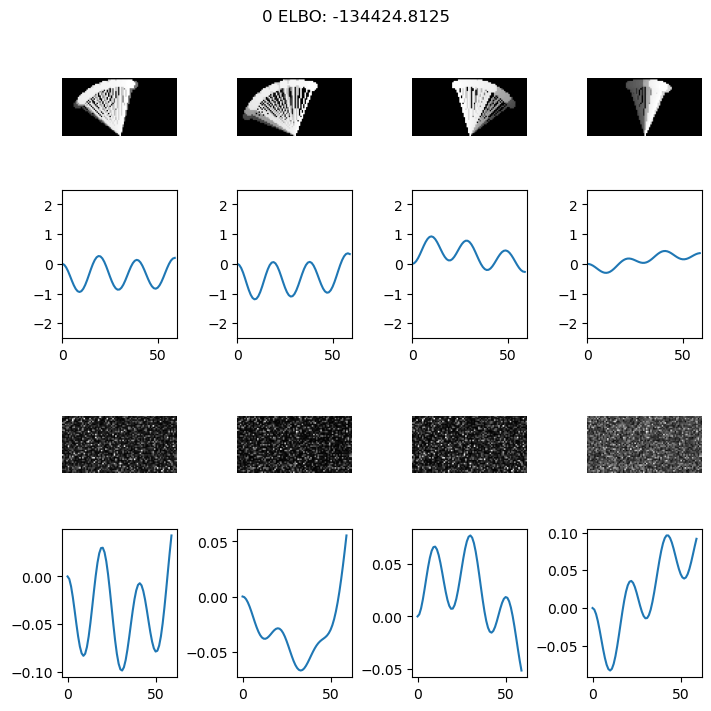

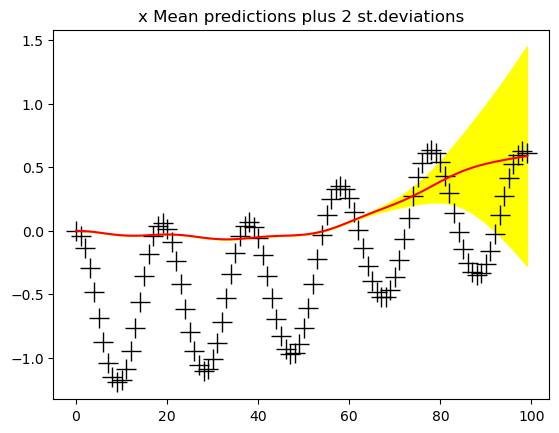

/tmp/ipykernel_1828120/447662804.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss += nn.MSELoss()(torch.tensor(rp, device=device).view(-1, 1), target.to(device))



Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

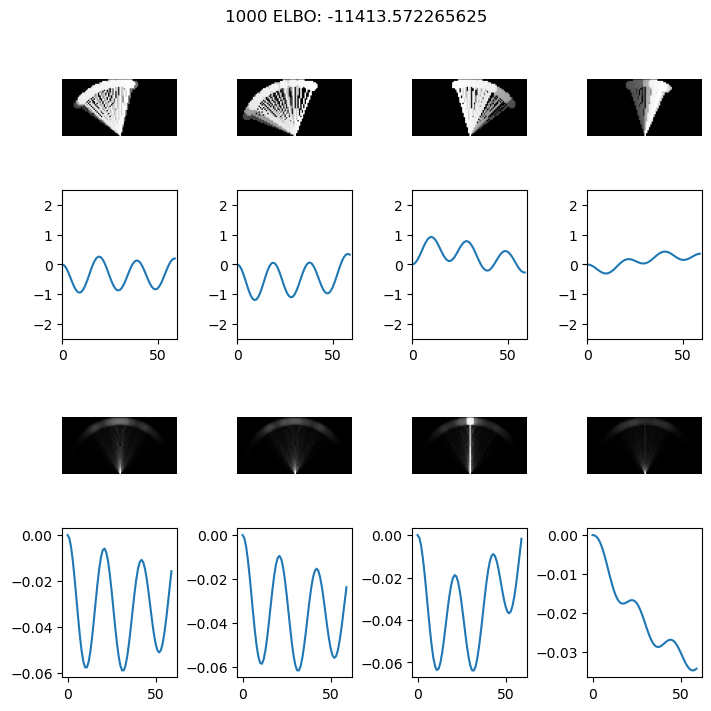

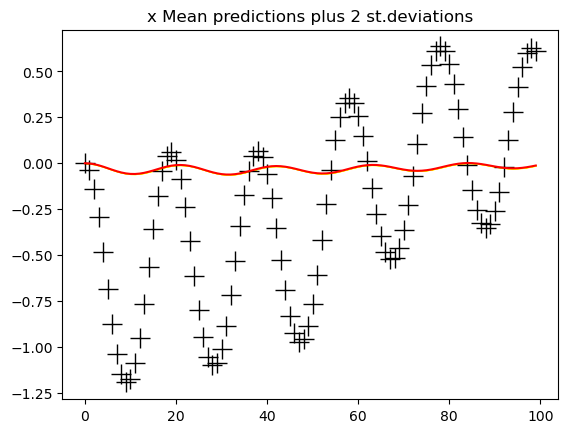


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

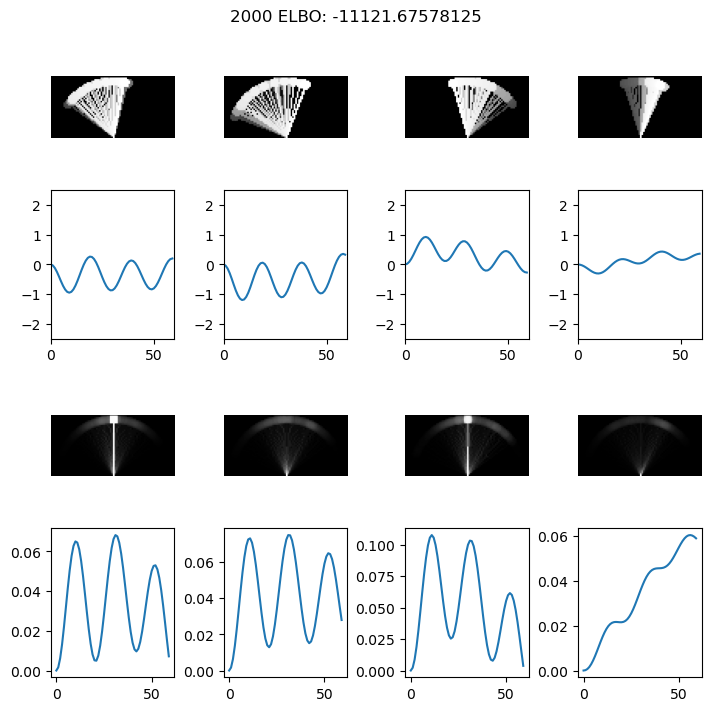

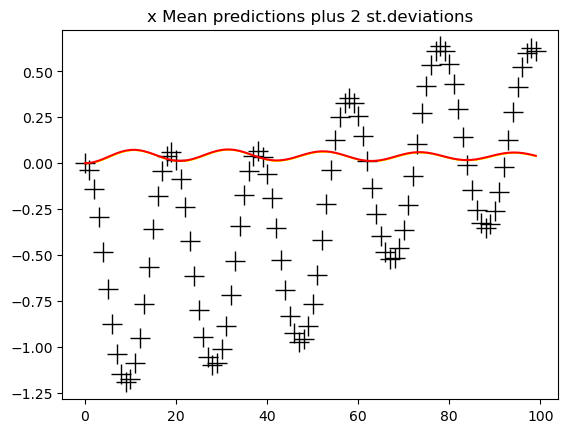


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

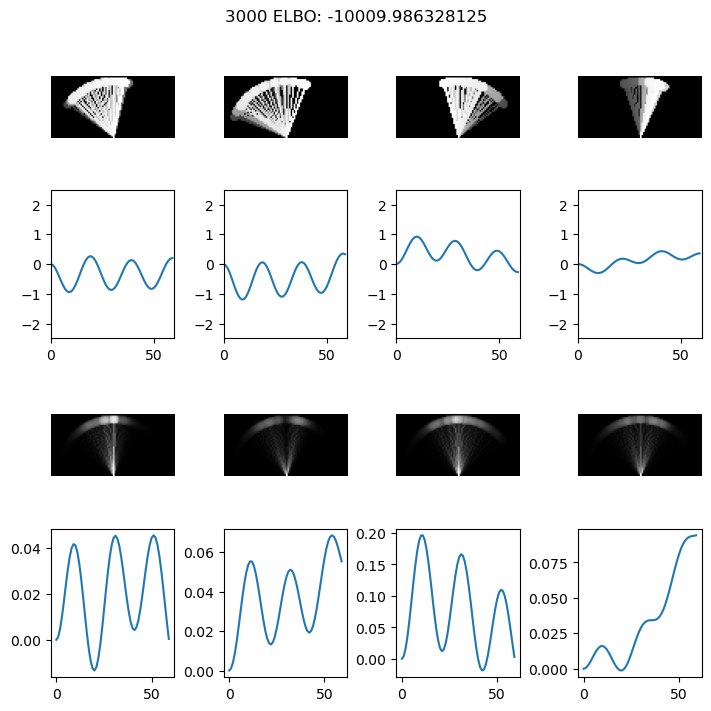

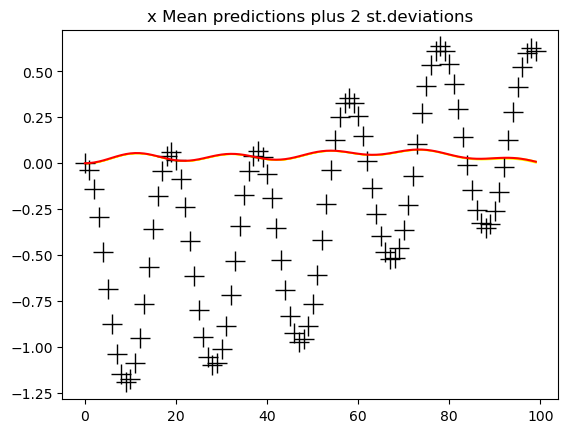


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

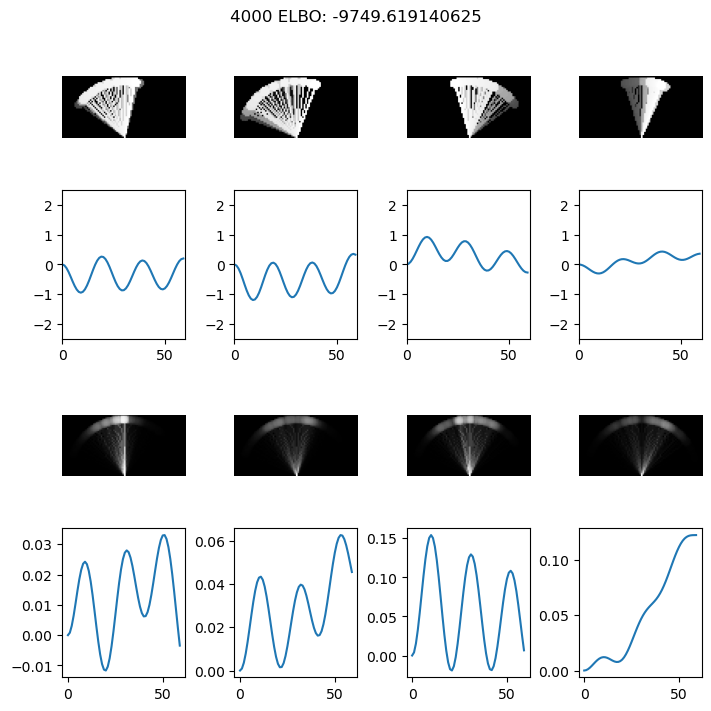

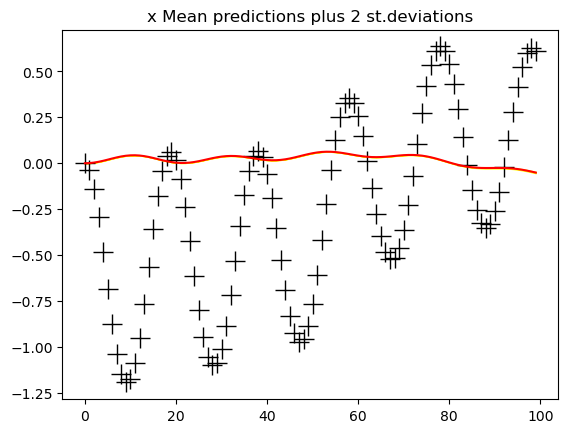


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

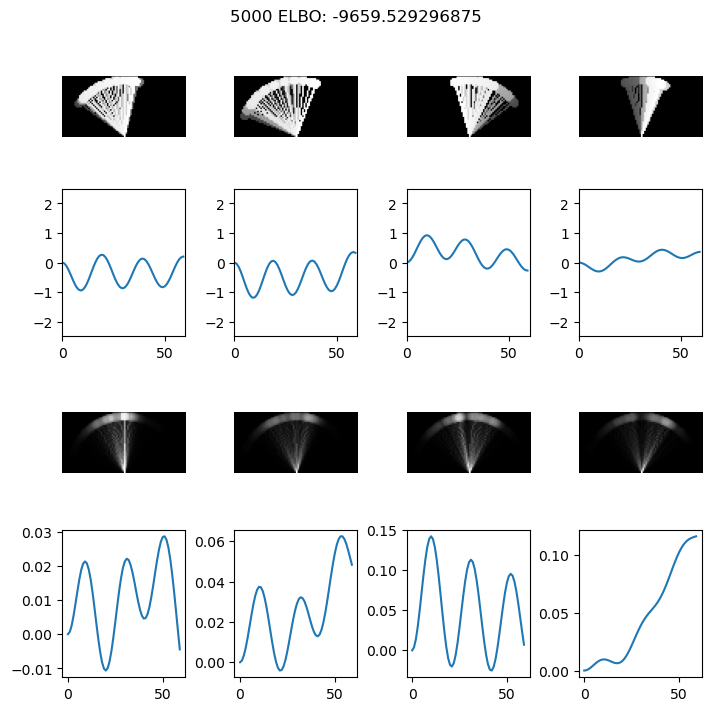

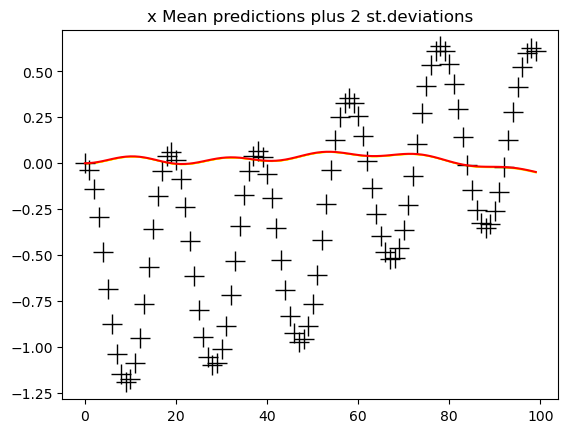


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

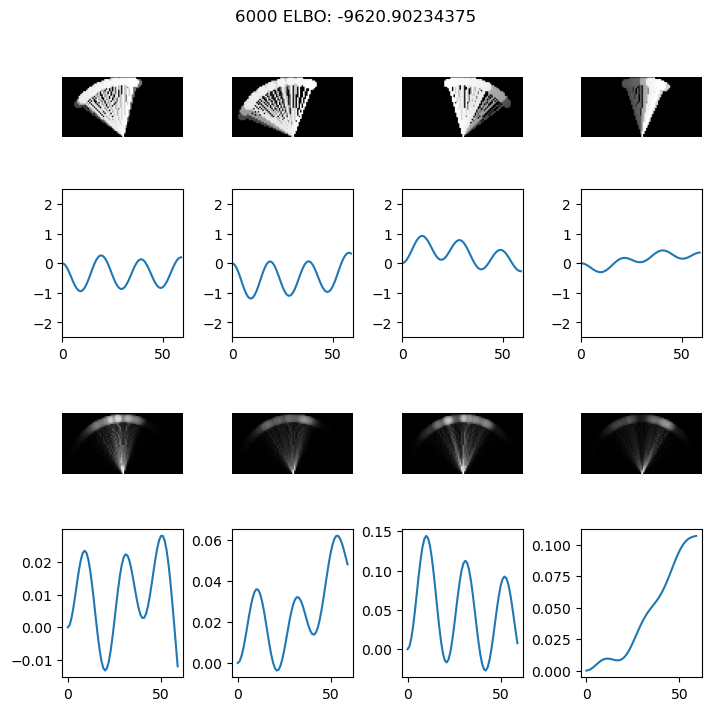

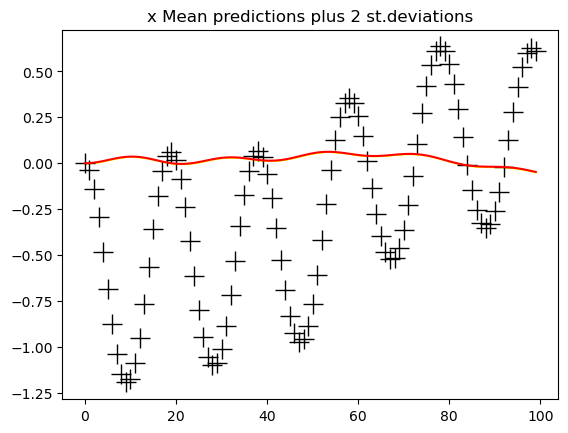


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

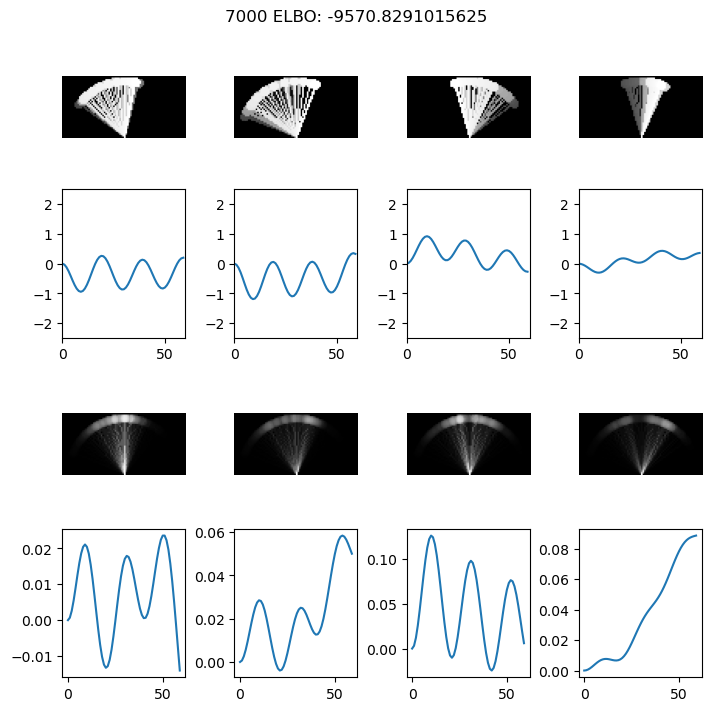

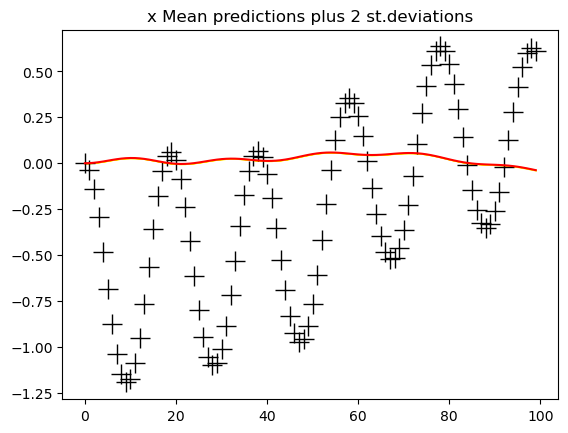


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

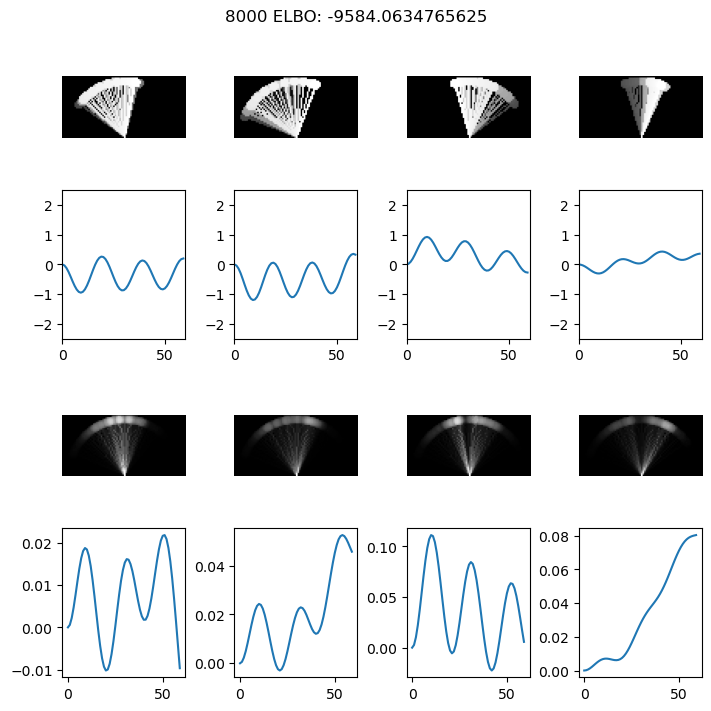

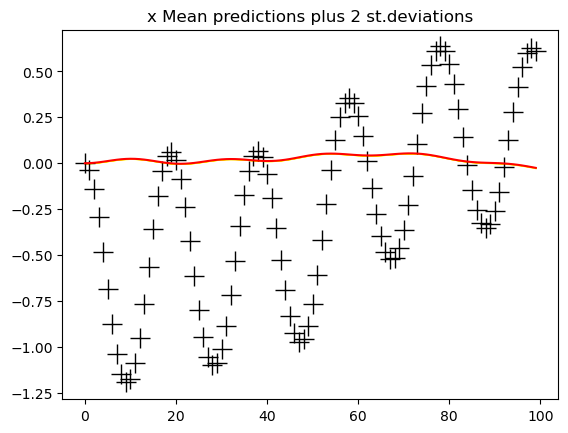


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

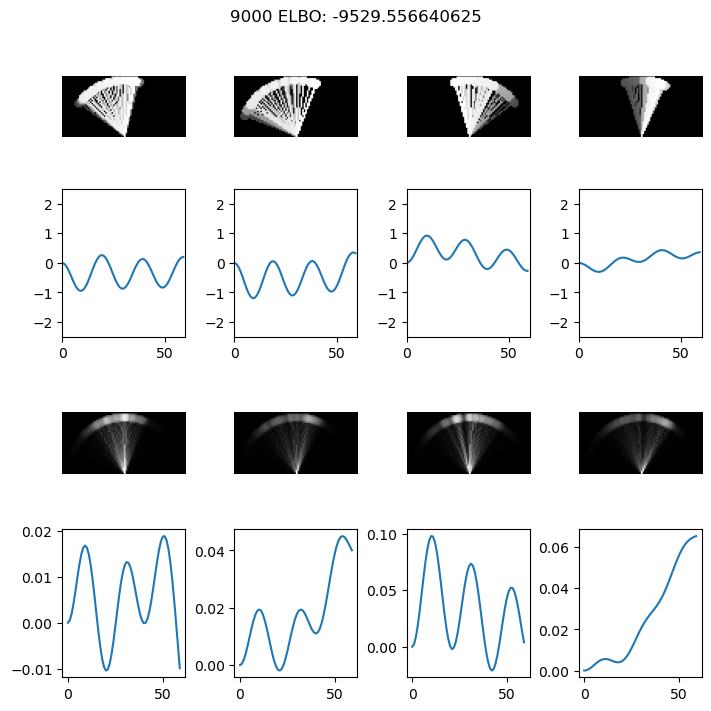

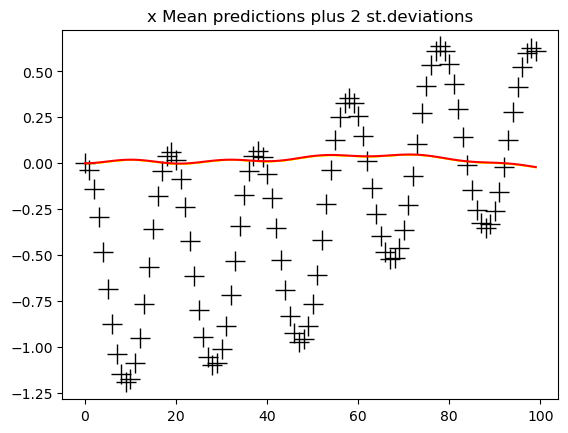


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

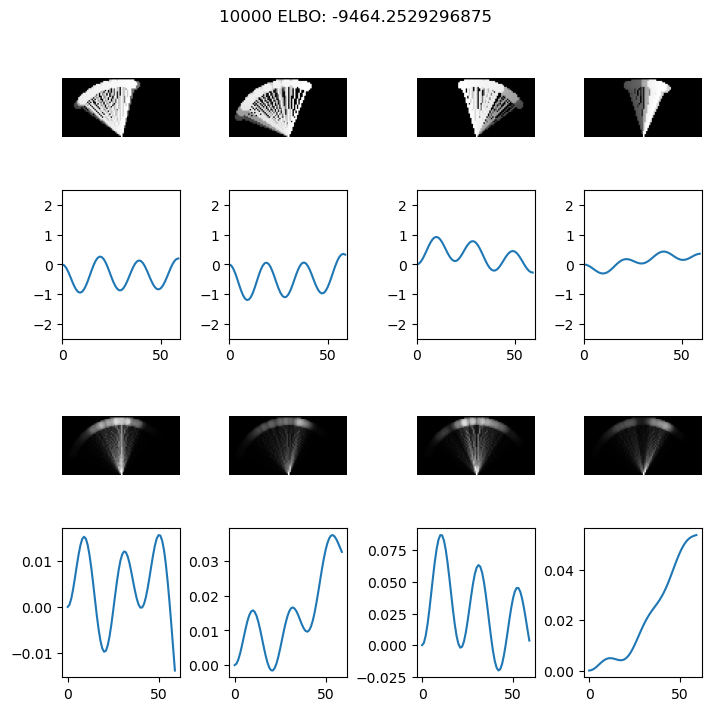

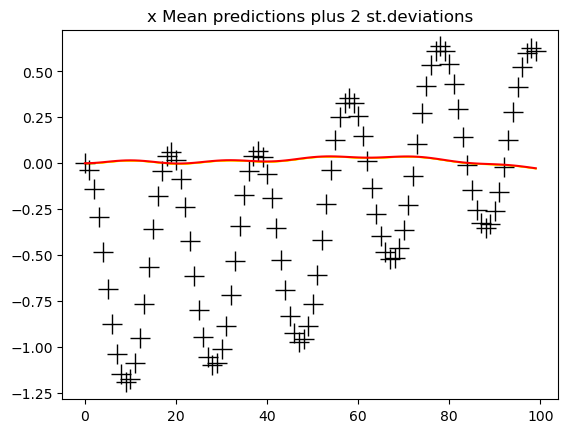


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

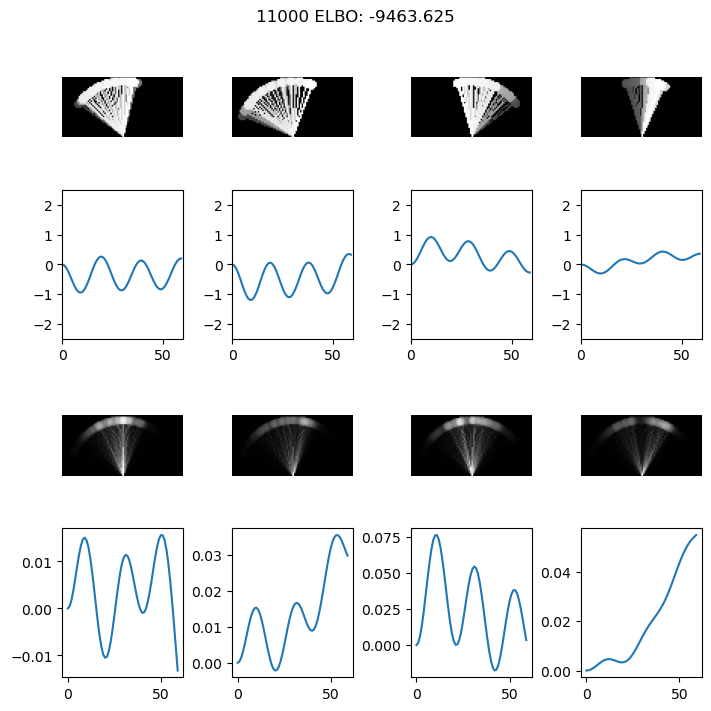

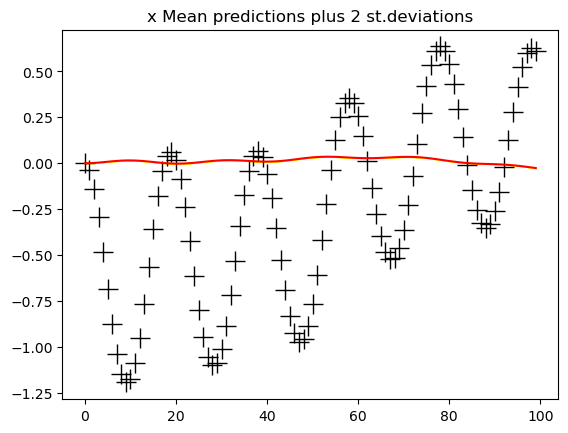


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

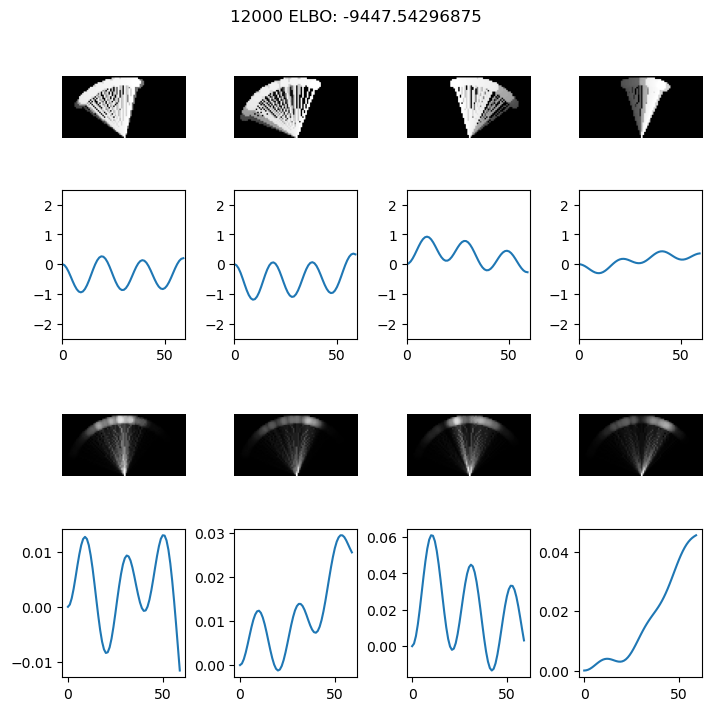

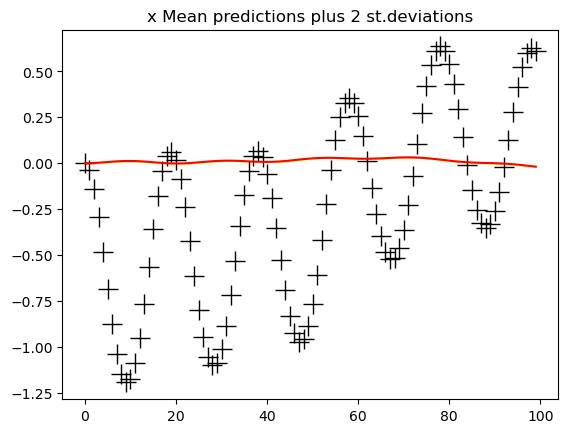


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

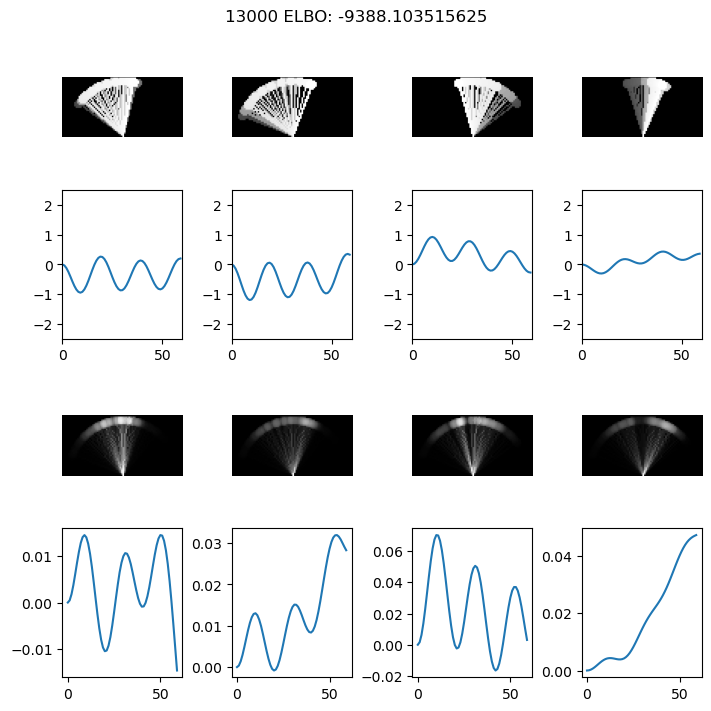

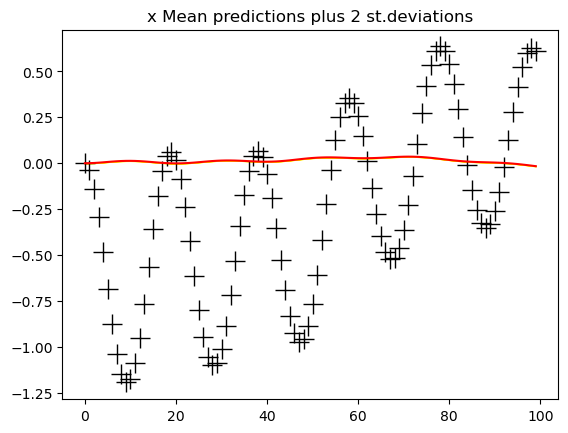


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

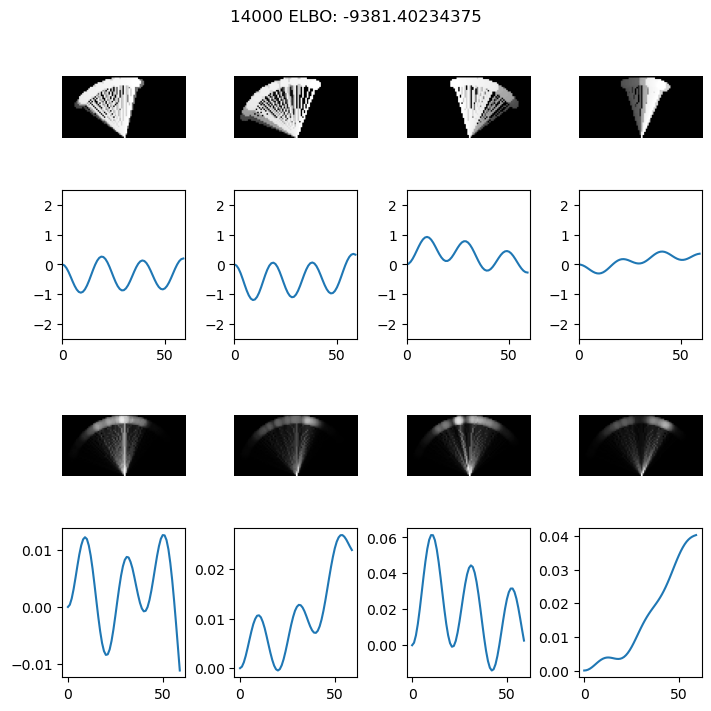

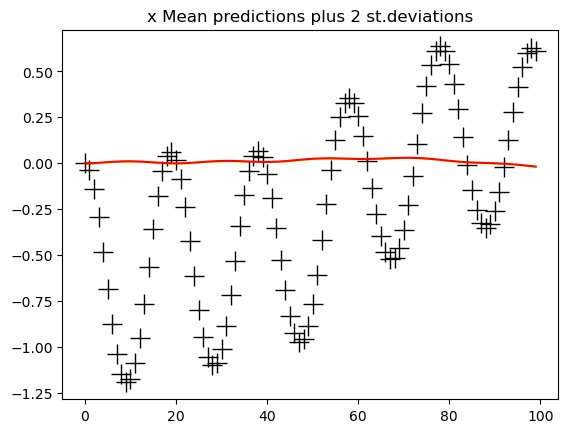


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

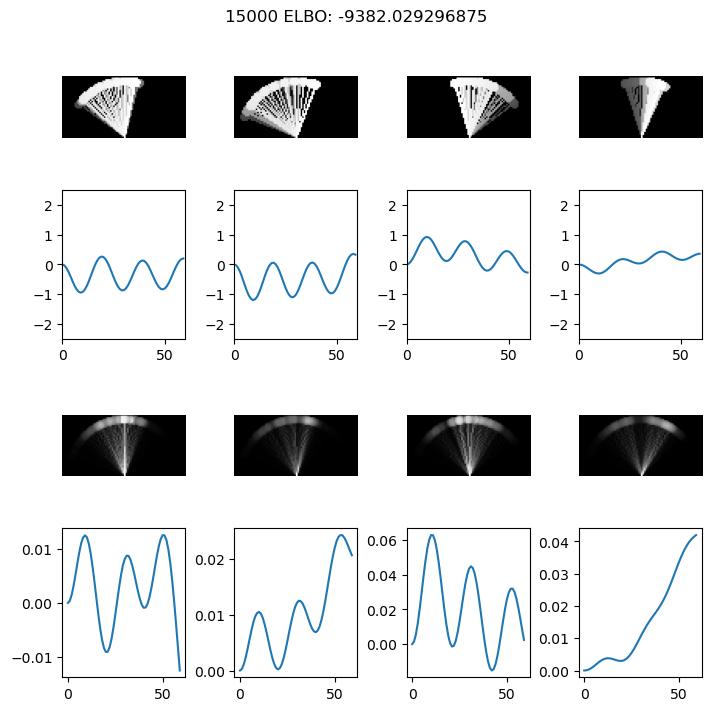

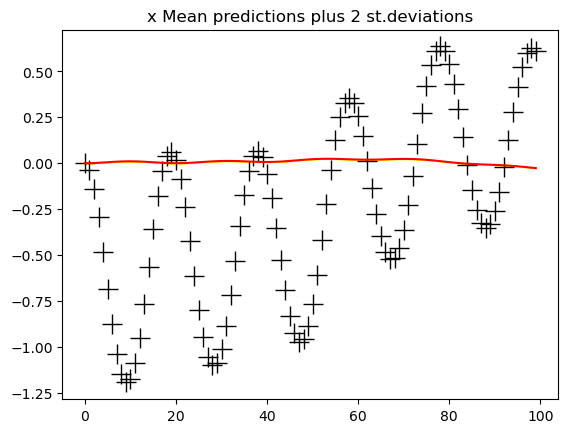


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

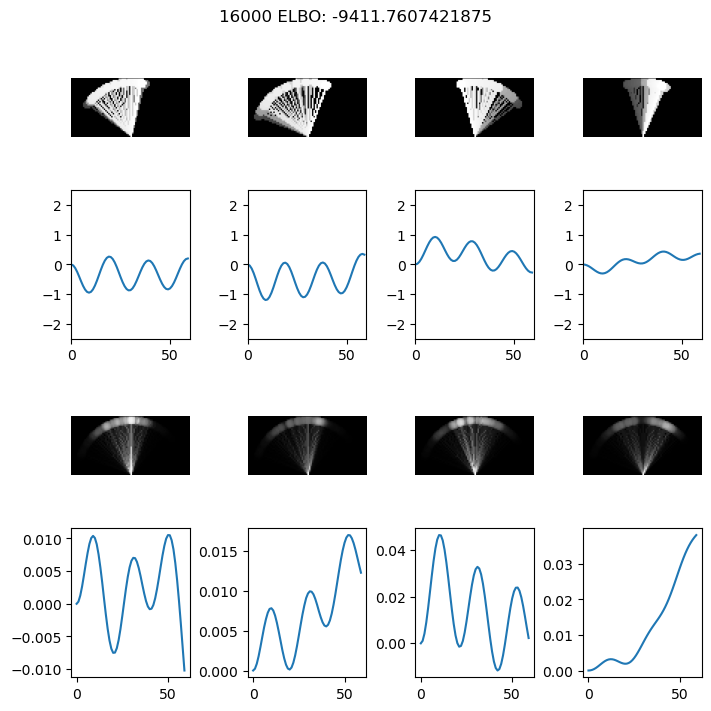

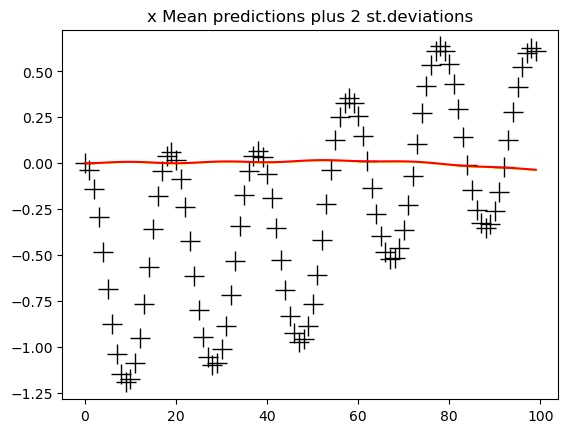


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

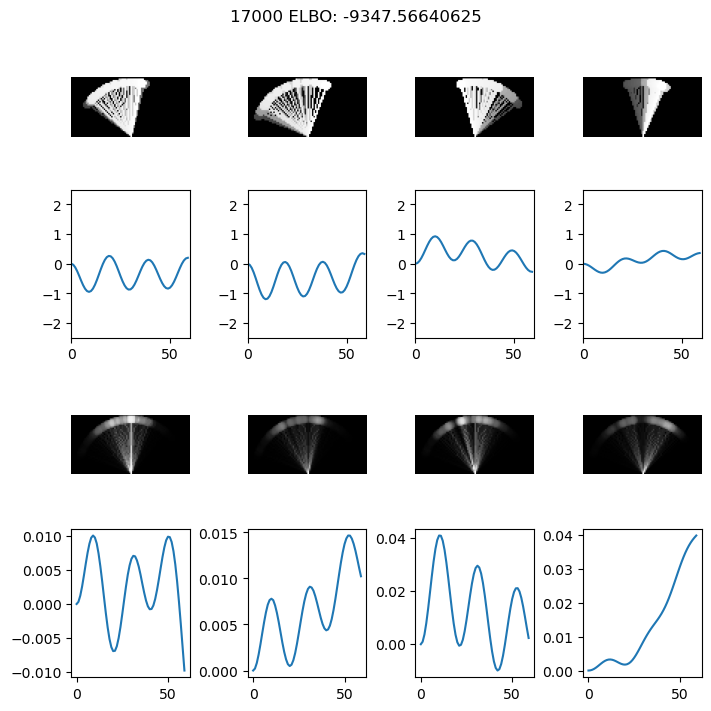

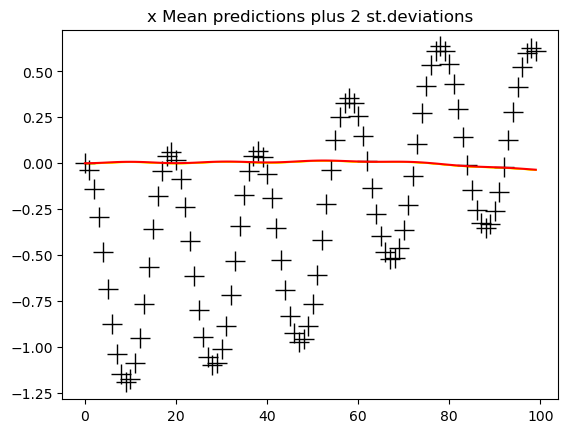


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

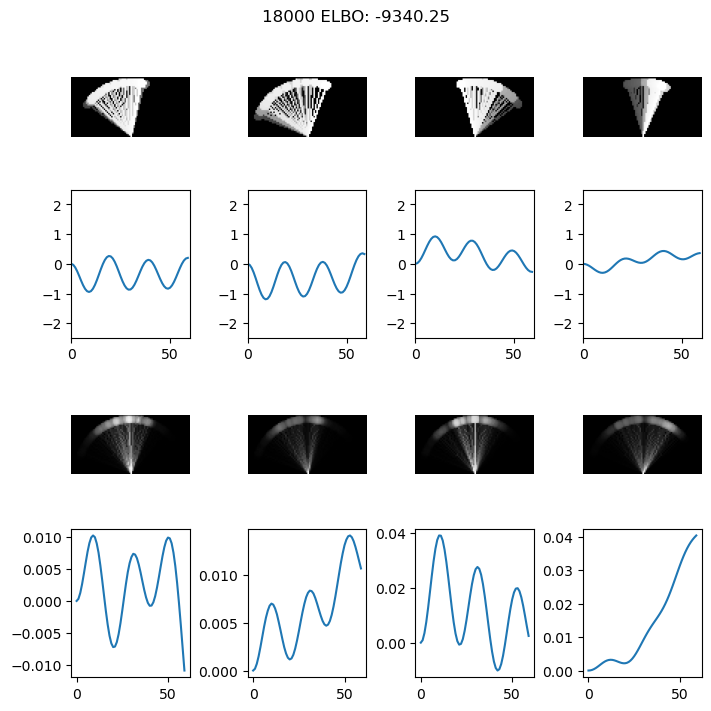

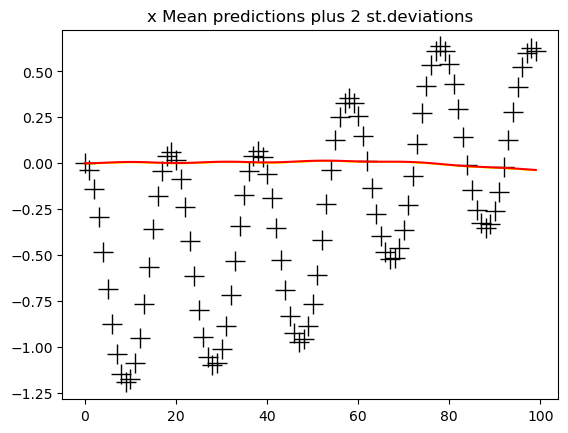


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

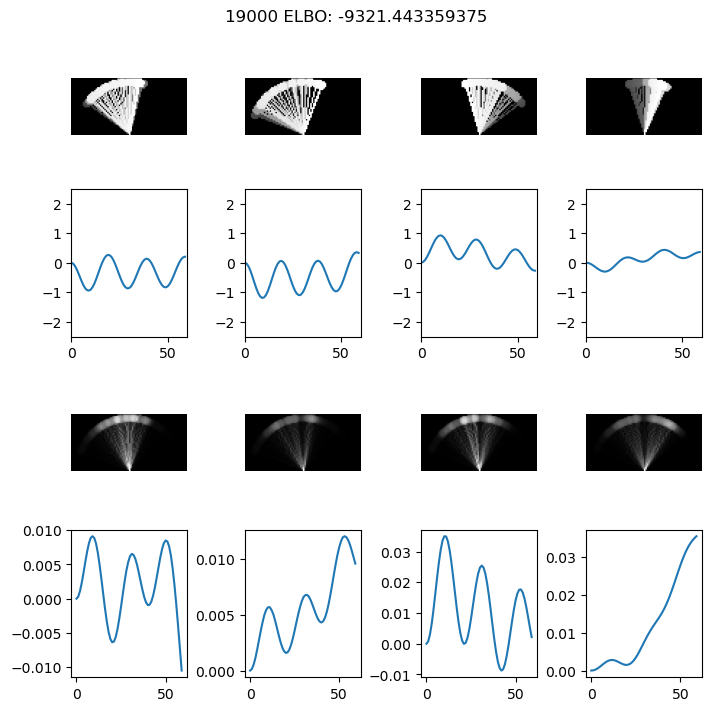

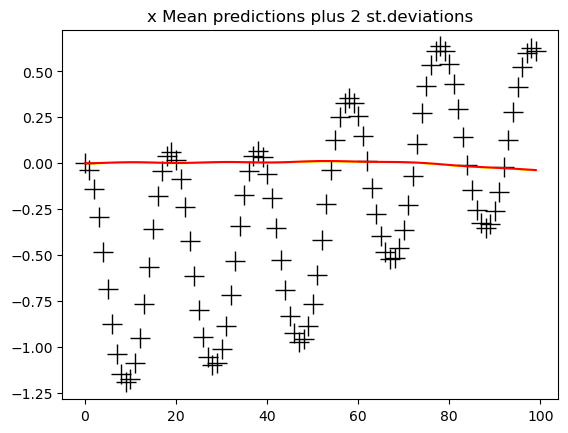


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

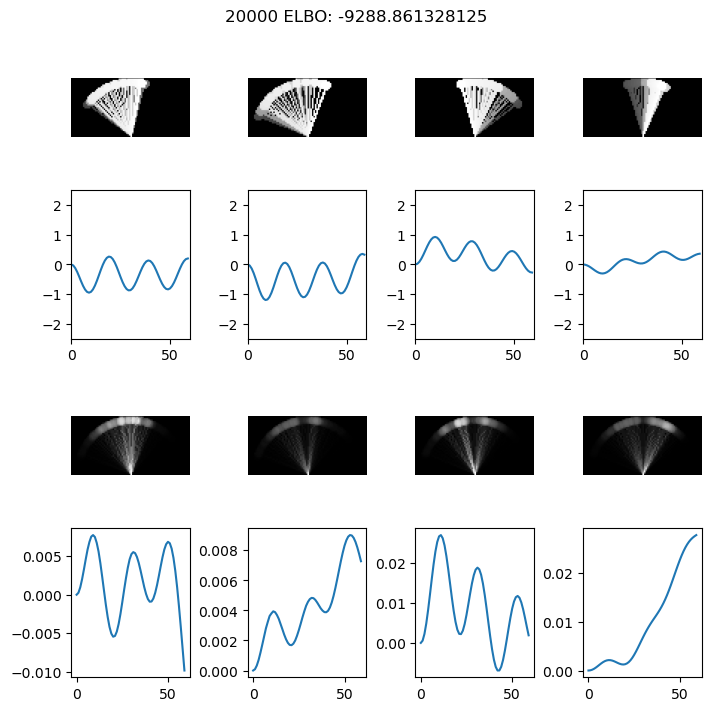

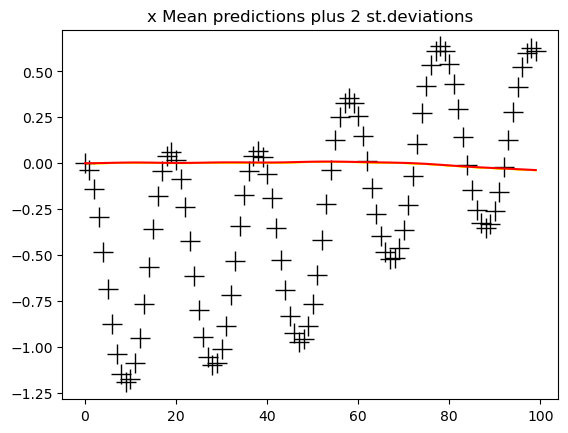


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

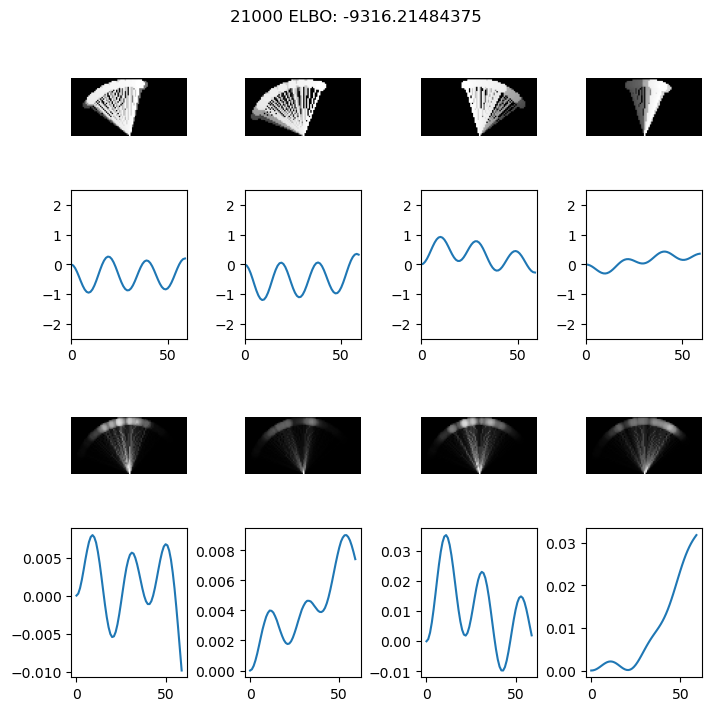

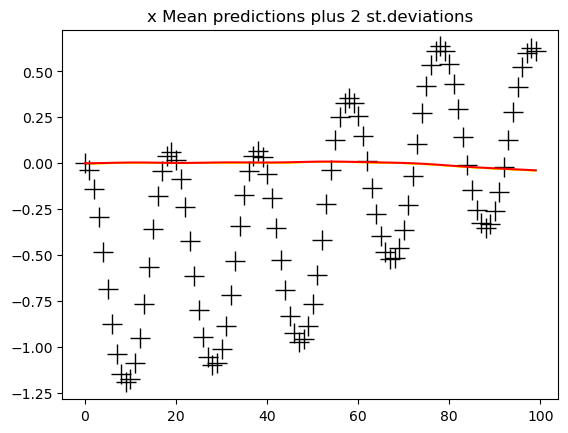


Test set: Avg. loss: 0.0000



<Figure size 640x480 with 0 Axes>

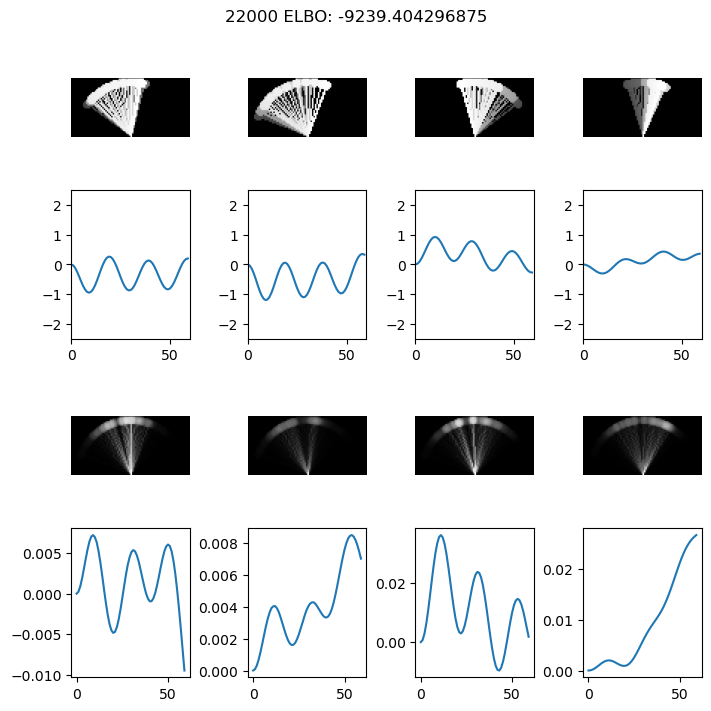

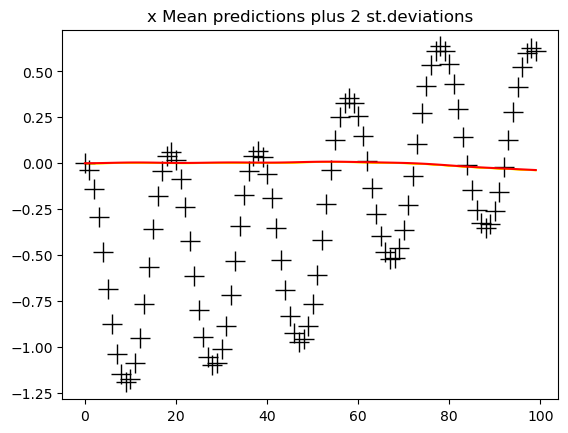


Test set: Avg. loss: 0.0000


Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

<Figure size 640x480 with 0 Axes>

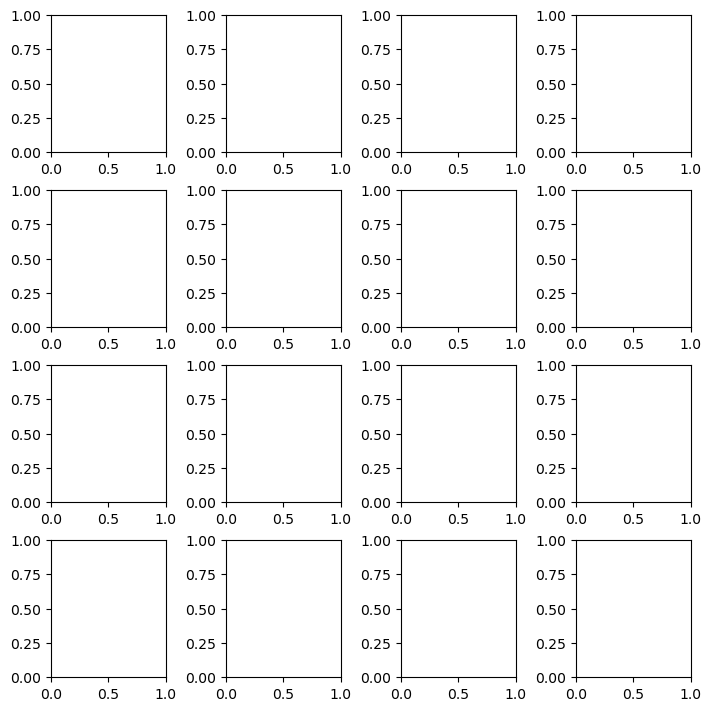

In [52]:
args_steps=50000 #Number of steps of Adam
args_modellt=50. #time scale of model to fit to data
args_base_dir="./" #folder within a new dir is made for each run
args_l1=0.3
args_l2=0.4
args_d1=0.02
args_d2=0.01

run_experiment(args_steps,args_modellt,args_base_dir,args_l1,args_l2,args_d1,args_d2)